In [1106]:
import torch

from torch.distributions import MultivariateNormal, MixtureSameFamily, Categorical
from matplotlib import pyplot as plt
from einops import rearrange, repeat, reduce
from sklearn.cluster import KMeans
from tqdm import tqdm

# Data generating process

In [1135]:
means = torch.tensor([[-1, 1], [0,0], [1, 1]]).float()
m = MultivariateNormal(means, torch.stack([torch.eye(2)]*3))
mm = MixtureSameFamily(Categorical(torch.tensor([0.2]*3)), m)
samples = mm.sample(torch.tensor([10000]))

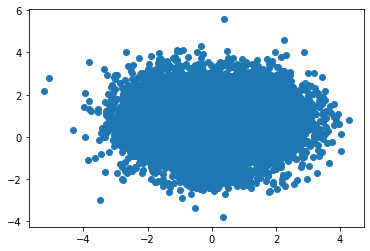

In [1136]:
plt.scatter(samples[:, 0], samples[:, 1])

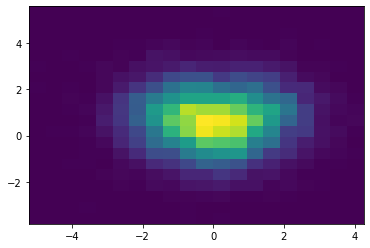

In [1137]:
img, x_grid, y_grid, _ = plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins = [20, 20])

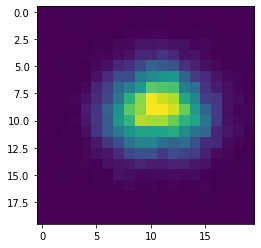

In [1138]:
plt.imshow(img.transpose())

# Estimating model using EM algorithm

To implement the EM algorithm, we need the truncated normal distribution:

- Implementation of truncated multivariate distribution in R: tmvtnorm package
- This could be useful: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html


In [1139]:
## Basic EM algorithm
from sklearn.cluster import KMeans

samples_pixel = samples.int() + 0.5
km = KMeans(n_clusters=3)
km.fit(samples_pixel)
km.cluster_centers_

array([[1.85195798, 0.86389685],
       [0.14519294, 1.89012426],
       [0.16460396, 0.36881188]])

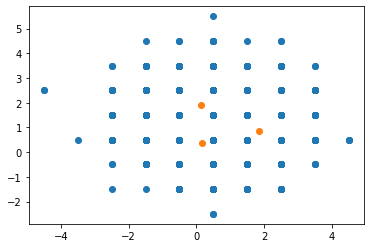

In [1140]:
plt.scatter(samples_pixel[:, 0], samples_pixel[:, 1])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])

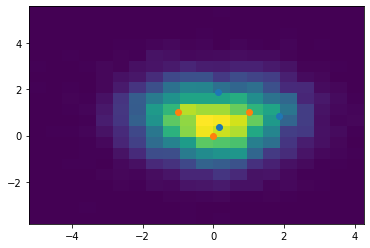

In [1141]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=[20,20])
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [1142]:
km.cluster_centers_

array([[1.85195798, 0.86389685],
       [0.14519294, 1.89012426],
       [0.16460396, 0.36881188]])

In [1143]:
limits.shape

(20, 20, 4)

In [1144]:
def basic_em(grid, limits, mu_start, pi_start, n_iter, fast_mean=False):
    grid_long = rearrange(grid, "X Y -> (X Y)")
    limits_long = rearrange(limits, "X Y L -> (X Y) L")
    limits_lower_long = limits_long[:, [0,2]]
    limits_upper_long = limits_long[:, [1,3]]

    
    dim_X, dim_Y = grid.shape
    centered_vals_long = (limits_lower_long + limits_upper_long) / 2
    centered_vals = rearrange(centered_vals_long, "(X Y) L -> X Y L", X=dim_X, Y=dim_Y)
    mu = np.copy(mu_start)
    pi = np.copy(pi_start)
    for _ in tqdm(range(n_iter)):
        ## E-step
        ## Calculate log-probability of each cluster
        probs_list = []
        for j in range(mu.shape[0]):
            ## Get expectation in each pixel
            #res = tm.mtmvnorm(mus[j], None, limits_long[:, [0,2]], limits_long[:, [1,3]])
            #res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=10, Y=10)
            #res_var = rearrange(res[1], "(X Y) A B -> X Y A B", X=10, Y=10)
            ## Calculate the log-probability
            probs_j = tm.pmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
            probs_list.append(probs_j)
        probs_long = np.stack(probs_list)
        #return(probs_long)
        #print(probs_long)
        probs = rearrange(probs_long, "K (X Y) 1 -> K X Y", X=dim_X, Y=dim_Y)
        #return probs
        ## Multiply by the prior
        probs = rearrange(pi, "K -> K 1 1") * probs
        probs = probs / reduce(probs, "K X Y -> 1 X Y", "sum")

        ## M-step
        prob_global = reduce((probs * grid), "K X Y -> K", "sum")
        pi = prob_global / prob_global.sum()
        
        for j in range(mu.shape[0]):
            probs_j = probs[j]
            #print(probs_j.shape)
            W = rearrange(probs_j * grid, "X Y -> X Y 1")
            #eturn probs_j, W
            

            if fast_mean:
                res_mean = centered_vals
            else:
                res = tm.mtmvnorm(mu[j], None, limits_lower_long, limits_upper_long)
                res_mean = rearrange(res[0], "(X Y) A -> X Y A", X=dim_X, Y=dim_Y)
            #return res_mean
            #return res[0]
            mu[j] = reduce(W * res_mean, "X Y A -> A", "sum")
            mu[j] = mu[j] / (W).sum()
            #print(mu[j])
    return mu, pi, probs

In [1145]:
output = basic_em(img, limits, km.cluster_centers_, np.ones(3)/3, 20)

100%|██████████████████████████████████████████████████| 20/20 [02:26<00:00,  7.34s/it]


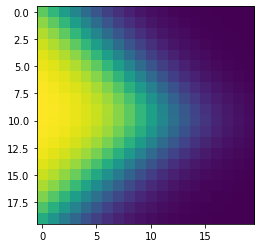

In [1126]:
plt.imshow(output[2][2])

In [1127]:
#output[1].max()

In [1128]:
output

(array([[ 1.01274423,  1.09595717],
        [-1.02767843,  1.18228036],
        [-0.04820382,  0.11085678]]),
 array([0.28198593, 0.27767184, 0.44034223]),
 array([[[6.81357019e-05, 8.79941236e-05, 1.09235922e-04, ...,
          1.40113143e-04, 1.35107697e-04, 1.30244571e-04],
         [1.19274189e-04, 1.59300394e-04, 2.05741281e-04, ...,
          3.39941840e-04, 3.27936418e-04, 3.16221442e-04],
         [2.03224618e-04, 2.78746664e-04, 3.72282886e-04, ...,
          8.23698221e-04, 7.95123840e-04, 7.67051600e-04],
         ...,
         [2.03029606e-01, 2.71718214e-01, 3.53304595e-01, ...,
          9.92027755e-01, 9.93828442e-01, 9.95034859e-01],
         [2.88889305e-01, 3.73041171e-01, 4.65619423e-01, ...,
          9.95419367e-01, 9.96572104e-01, 9.97349676e-01],
         [3.93180898e-01, 4.86918948e-01, 5.81556291e-01, ...,
          9.97302370e-01, 9.98034405e-01, 9.98530332e-01]],
 
        [[2.57831024e-01, 3.45606457e-01, 4.45303621e-01, ...,
          9.97526133e-01, 9.9832

In [1129]:
np.ones(3)/3

array([0.33333333, 0.33333333, 0.33333333])

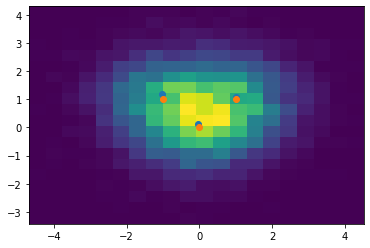

In [1130]:
plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=[20,20])
plt.scatter(output[0][:, 0], output[0][:, 1])
plt.scatter(means[:, 0], means[:, 1])

In [936]:
km.cluster_centers_

array([[ 0.50102171,  0.51532567],
       [-1.04844498,  2.2263756 ],
       [ 2.37632251,  2.09686246]])

- Almost spot on when "galaxies" are clearly separated (4, -4), (0,0), (4, 4)
- (FIXED; this was a bug in code) EM converges to center when closer together
- Works well for (1, -1), (0, 0), (1, 1)

- Works for 3